<a href="https://colab.research.google.com/github/Garima27dec/Emotion-Detection-with-Multiple-Data-Streams/blob/main/Models_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importing and installing Libraries**

In [79]:
!pip install -U tensorflow-text==2.12.0
!pip3 install opencv-python
!pip install pydub
!pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 36.2 MB/s eta 0:00:00


In [80]:
import tensorflow_hub as hub
import tensorflow_text as text
import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import shutil
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM,Dropout,TimeDistributed, Flatten, Bidirectional, Input
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
import re
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import glob
import statistics
from scipy.ndimage import zoom
from os import path
from pydub import AudioSegment
import librosa
import IPython
from IPython.display import Audio, Image
import speech_recognition

##**Connecting to Storage - to import saved models**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Loading Face, Speech, Text Emotion Recognition Models**

In [4]:
from keras.models import model_from_json
with open('/content/drive/MyDrive/FER/model_3.json','r') as f:
    json = f.read()
model_fer = model_from_json(json)

model_fer.load_weights('/content/drive/MyDrive/FER/model_3.h5')
print("Loaded FER model from disk")

Loaded FER model from disk


In [5]:
from keras.models import load_model
model_ser = load_model('/content/drive/MyDrive/SER/[CNN-LSTM]M.h5')

model_ser.load_weights('/content/drive/MyDrive/SER/[CNN-LSTM]W.h5')
print("Loaded SER model from disk")

Loaded SER model from disk


In [6]:
model_ter = tf.keras.models.load_model(('/content/drive/MyDrive/TEXT/BERT_M.h5'), custom_objects={'KerasLayer':hub.KerasLayer})
model_ter.load_weights('/content/drive/MyDrive/TEXT/BERT_W.h5')
print("Loaded Text_ER model from disk")

Loaded Text_ER model from disk


##**Defining functions for Data Pre-processing**

In [7]:
shape_x = 48
shape_y = 48

In [8]:
def detect_face(frame):

    #Cascade classifier pre-trained model
    cascPath = '/content/drive/MyDrive/FER/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)

    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []

    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            #cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])

    return gray, detected_faces, coord

In [9]:
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]

    new_face = []

    for det in detected_face :

        x, y, w, h = det


        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]


        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)

        new_face.append(new_extracted_face)

    return new_face

In [10]:
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("/content/Results/"+"image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames


In [11]:
def get_label_fer(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

In [12]:
def get_label_ser(argument):
    labels = {0:'Neutral', 1:'Happy', 2:'Sad', 3:'Angry', 4:'Fear' , 5:'Disgust', 6:'Surprise'}
    return(labels.get(argument, "Invalid emotion"))

In [13]:
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):

    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2

    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)

    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

    return mel_spect

In [14]:
# Time distributed parameters
win_ts = 128
hop_ts = 64

# Split spectrogram into frames
def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames

In [15]:
def text_prediction(test_string):
  class_prob = model_ter.predict(test_string, batch_size=1)[0]
  if np.argmax(class_prob)==0:
    return("Angry")
  elif np.argmax(class_prob)==1:
    return("Disgust")
  elif np.argmax(class_prob)==2:
    return("Fear")
  elif np.argmax(class_prob)==3:
    return("Happy")
  elif np.argmax(class_prob)==4:
    return("Neutral")
  elif np.argmax(class_prob)==5:
    return("Sad")
  else:
    return("Surprise")

In [81]:
df = pd.read_csv("dev_sent_emo.csv")

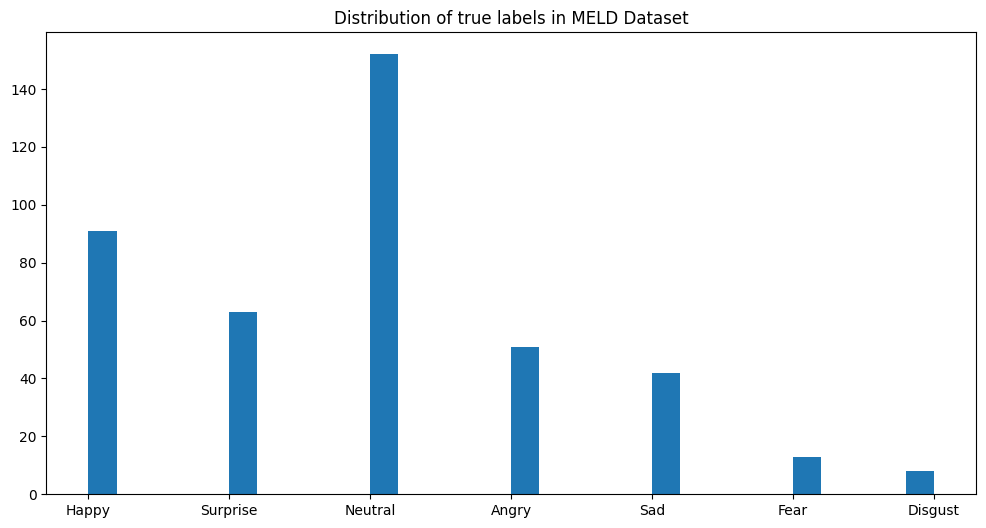

In [82]:
plt.figure(figsize=(12,6))
plt.hist(df['True_Emotion'], bins=30)
plt.title("Distribution of true labels in MELD Dataset")
plt.show()

#**Evaluating FER Model**

In [37]:
src1 = glob.glob('/content/drive/MyDrive/Emotion_Recognition/Model_Testing/dev_splits_complete/*')

In [23]:
emotion_fer =[]
prob_fer = []
file_fer = []

for x in src1:
  file_fer.append(x)
  vidcap = cv2.VideoCapture(x)

  sec = 0
  frameRate = 0.5 #//it will capture image in each 0.5 second
  count=1
  success = getFrame(sec)
  while success:
      count = count + 1
      sec = sec + frameRate
      sec = round(sec, 2)
      success = getFrame(sec)

  emotions = []
  emotions_prob = []

  source = glob.glob('/content/Results/*')

  for i in source:
      face = cv2.imread(i)
      for face in extract_face_features(detect_face(face)) :
        to_predict = np.reshape(face.flatten(), (1,48,48,1))
        res1 = model_fer.predict(to_predict)
        result_num = np.argmax(res1)
        prob = np.amax(res1)
        emotion_per_frame = get_label_fer(result_num)
        #print (emotion_per_frame)
        emotions.append(emotion_per_frame)
        emotions_prob.append(prob)

  if len(emotions)==0:
    emotion_fer.append("No Emotion")
    prob = 0
    prob_fer.append(prob)
  else:
    emotion_fer.append(statistics.mode(emotions))
    prob_fer.append(statistics.mean(emotions_prob))


  #print(emotions)
  #print("Emotion from FER: ", statistics.mode(emotions))
  #print("Emotion Probability: ", statistics.mean(emotions_prob))


  folder_path = '/content/Results/'

  for root, dirs, files in os.walk(folder_path):
      for file in files:
          if file.endswith('.jpg'):
              os.remove(os.path.join(root, file))

1/1 [==============================] - 0s 22ms/step


<ipython-input-9-62d6636c3fdd>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
<ipython-input-9-62d6636c3fdd>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
D

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
1/1 [==============================] - 0s 21ms/step


KeyboardInterrupt: ignored

In [49]:
FaceResults = pd.DataFrame()

In [54]:
file_fer = []

for x in src1[:420]:
  file_fer.append(x)

In [55]:
FaceResults["File"] = file_fer
FaceResults["Face_Emotion"] = emotion_fer
FaceResults["Face_Emotion_Prob"] = prob_fer

In [56]:
FaceResults.head()

,File,Face_Emotion,Face_Emotion_Prob
0,/content/drive/MyDrive/Emotion_Recognition/Mod...,No Emotion,0.000000
1,/content/drive/MyDrive/Emotion_Recognition/Mod...,Angry,0.620492
2,/content/drive/MyDrive/Emotion_Recognition/Mod...,Neutral,0.773492
3,/content/drive/MyDrive/Emotion_Recognition/Mod...,Angry,0.680585
4,/content/drive/MyDrive/Emotion_Recognition/Mod...,Angry,0.740923


In [58]:
FaceResults.to_csv('/content/Face_Emotion.csv', index=False)

In [83]:
from sklearn.metrics import classification_report

In [84]:
df1 = pd.read_csv("dev_sent_emo.csv")

In [85]:
df1.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,FER_Prob,Predicted_Emotion_SER,SER_Prob,Predicted_Emotion_Text,TER_Prob,Predicted_Emotion_Ensemble,Predicted_Emotion_Ensemble_Probability
0,1,Hey!,All,Happy,positive,1,5,4,4,"0:12:44,074","0:12:45,189",dia1_utt5.mp4,Happy,0.837637,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Where?!,Rachel,Surprise,negative,1,7,4,4,"0:12:52,730","0:12:55,002",dia1_utt7.mp4,Sad,0.734680,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Really?!,Estelle,Surprise,positive,2,3,6,4,"0:09:13,594","0:09:14,476",dia2_utt3.mp4,Angry,0.530724,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Yeah!!,Ross,Happy,positive,3,1,5,20,"0:01:02,271","0:01:03,961",dia3_utt1.mp4,Happy,0.786309,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Wow! Whoa-whoa whats under the covers?,Rachel,Surprise,negative,15,4,8,7,"00:21:05,055","00:21:07,473",dia15_utt4.mp4,No Emotion,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
df1 = df1[df1["Predicted_Emotion_FER"].str.contains("No Emotion") == False]

In [87]:
y_true = df1['True_Emotion']
y_pred = df1['Predicted_Emotion_FER']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       Angry       0.30      0.30      0.30        50
     Disgust       0.00      0.00      0.00         8
        Fear       0.10      0.25      0.14        12
       Happy       0.45      0.49      0.47        86
     Neutral       0.48      0.38      0.43       151
         Sad       0.17      0.46      0.25        41
    Surprise       1.00      0.02      0.03        60

    accuracy                           0.34       408
   macro avg       0.36      0.27      0.23       408
weighted avg       0.48      0.34      0.33       408



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
labels = np.unique(y_true)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index=labels, columns=labels)

Text(95.72222222222221, 0.5, 'Truth')

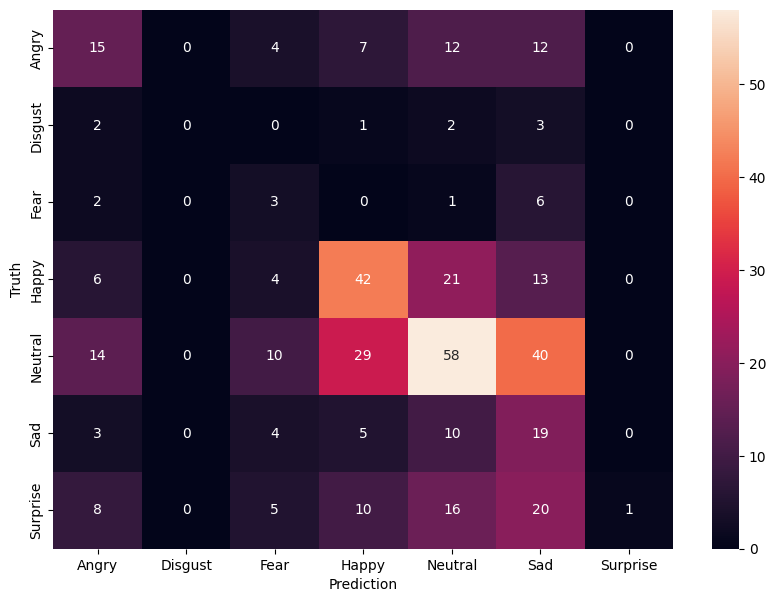

In [89]:

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')


#**Evaluating SER Model**

In [66]:
testsrc = src1[:740]

In [67]:
emotion_ser =[]
file_ser = []
prob_ser = []

for x in testsrc:
  file_ser.append(x)

  dst = "/content/wav_files/test0.wav"

  sound = AudioSegment.from_file(x,format="mp4")
  sound.export(dst, format="wav")

  # Sample rate (16.0 kHz)
  sample_rate = 16000

  # Max pad lenght (3.0 sec)
  max_pad_len = 49100

          # Read audio file
  y, sr = librosa.core.load(dst, sr=sample_rate, offset=0.5)

          # Z-normalization
  y = zscore(y)

          # Padding or truncated signal
  if len(y) < max_pad_len:
    y_padded = np.zeros(max_pad_len)
    y_padded[:len(y)] = y
    y = y_padded
  elif len(y) > max_pad_len:
    y = np.asarray(y[:max_pad_len])

  # Data Preprocessing
  mel_spect = np.asarray(mel_spectrogram(y))
  mel_spect = np.reshape(mel_spect,(1,128,384))
  input = frame(mel_spect, hop_ts, win_ts)
  input = input.reshape(input.shape[0], input.shape[1] , input.shape[2], input.shape[3], 1)

  for speech in input:
      res = model_ser.predict(input)
      result_num2 = np.argmax(res)
      #print(result_num)
      #print("Emotion from SER:", get_label_ser(result_num2))
      #print("Emotion Probability: ", np.amax(res))
      emotion_ser.append(get_label_ser(result_num2))
      prob_ser.append(np.amax(res))


1/1 [==============================] - 0s 29ms/step


In [68]:
SpeechResults = pd.DataFrame()

In [69]:
SpeechResults["File"] = file_ser
SpeechResults["Speech_Emotion"] = emotion_ser
SpeechResults["Speech_Emotion_prob"] = prob_ser

In [70]:
SpeechResults.head()

,File,Speech_Emotion,Speech_Emotion_prob
0,/content/drive/MyDrive/Emotion_Recognition/Mod...,Surprise,0.999857
1,/content/drive/MyDrive/Emotion_Recognition/Mod...,Surprise,0.913592
2,/content/drive/MyDrive/Emotion_Recognition/Mod...,Happy,0.963841
3,/content/drive/MyDrive/Emotion_Recognition/Mod...,Surprise,0.957533
4,/content/drive/MyDrive/Emotion_Recognition/Mod...,Surprise,0.996701


In [71]:
SpeechResults.to_csv('/content/Speech_Emotion.csv', index=False)

In [90]:
df2 = pd.read_csv("dev_sent_emo.csv")

In [91]:
df2.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,FER_Prob,Predicted_Emotion_SER,SER_Prob,Predicted_Emotion_Text,TER_Prob,Predicted_Emotion_Ensemble,Predicted_Emotion_Ensemble_Probability
0,1,Hey!,All,Happy,positive,1,5,4,4,"0:12:44,074","0:12:45,189",dia1_utt5.mp4,Happy,0.837637,Surprise,0.998745,NaN,NaN,NaN,NaN
1,2,Where?!,Rachel,Surprise,negative,1,7,4,4,"0:12:52,730","0:12:55,002",dia1_utt7.mp4,Sad,0.734680,Surprise,0.966066,NaN,NaN,NaN,NaN
2,3,Really?!,Estelle,Surprise,positive,2,3,6,4,"0:09:13,594","0:09:14,476",dia2_utt3.mp4,Angry,0.530724,Surprise,0.972096,NaN,NaN,NaN,NaN
3,4,Yeah!!,Ross,Happy,positive,3,1,5,20,"0:01:02,271","0:01:03,961",dia3_utt1.mp4,Happy,0.786309,Surprise,0.514668,NaN,NaN,NaN,NaN
4,5,Wow! Whoa-whoa whats under the covers?,Rachel,Surprise,negative,15,4,8,7,"00:21:05,055","00:21:07,473",dia15_utt4.mp4,No Emotion,0.000000,Surprise,0.999857,NaN,NaN,NaN,NaN


In [92]:
y_true = df2['True_Emotion']
y_pred = df2['Predicted_Emotion_SER']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       Angry       0.20      0.02      0.04        51
     Disgust       0.00      0.00      0.00         8
        Fear       0.07      0.08      0.07        13
       Happy       0.29      0.51      0.37        91
     Neutral       0.41      0.22      0.28       152
         Sad       0.43      0.07      0.12        42
    Surprise       0.31      0.71      0.43        63

    accuracy                           0.31       420
   macro avg       0.24      0.23      0.19       420
weighted avg       0.33      0.31      0.27       420



In [93]:

labels = np.unique(y_true)
cm2 = confusion_matrix(y_true, y_pred)
cm2 = pd.DataFrame(cm2, index=labels, columns=labels)

Text(95.72222222222221, 0.5, 'Truth')

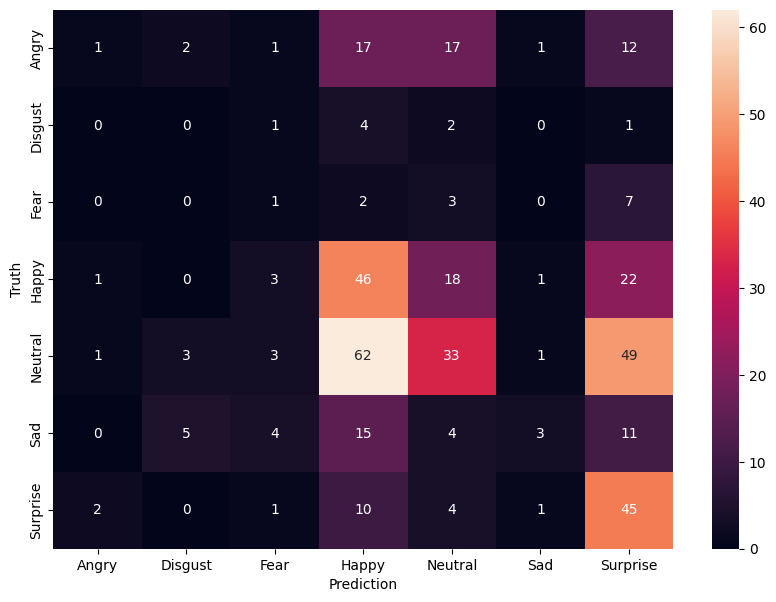

In [94]:
plt.figure(figsize = (10,7))
sn.heatmap(cm2, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

#**Evaluating Text_ER Model**

In [95]:
df3 = pd.read_csv("dev_sent_emo.csv")

In [96]:
df3.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,FER_Prob,Predicted_Emotion_SER,SER_Prob,Predicted_Emotion_Text,TER_Prob,Predicted_Emotion_Ensemble,Predicted_Emotion_Ensemble_Probability
0,1,Hey!,All,Happy,positive,1,5,4,4,"0:12:44,074","0:12:45,189",dia1_utt5.mp4,Happy,0.837637,Surprise,0.998745,NaN,NaN,NaN,NaN
1,2,Where?!,Rachel,Surprise,negative,1,7,4,4,"0:12:52,730","0:12:55,002",dia1_utt7.mp4,Sad,0.734680,Surprise,0.966066,NaN,NaN,NaN,NaN
2,3,Really?!,Estelle,Surprise,positive,2,3,6,4,"0:09:13,594","0:09:14,476",dia2_utt3.mp4,Angry,0.530724,Surprise,0.972096,NaN,NaN,NaN,NaN
3,4,Yeah!!,Ross,Happy,positive,3,1,5,20,"0:01:02,271","0:01:03,961",dia3_utt1.mp4,Happy,0.786309,Surprise,0.514668,NaN,NaN,NaN,NaN
4,5,Wow! Whoa-whoa whats under the covers?,Rachel,Surprise,negative,15,4,8,7,"00:21:05,055","00:21:07,473",dia15_utt4.mp4,No Emotion,0.000000,Surprise,0.999857,NaN,NaN,NaN,NaN


In [81]:
dialogue = df3['Utterance'].tolist()
file_ter = df3['File_Name_Concatenated'].tolist()

In [82]:
type(dialogue)

list

In [83]:
emotion_ter =[]
prob_ter = []


for i in dialogue:
  emotion_ter.append(text_prediction([i]))
  prob_ter.append(np.amax(model_ter.predict([i])))





1/1 [==============================] - 0s 68ms/step


In [84]:
TextResults = pd.DataFrame()

In [85]:
TextResults["File"] = file_ter
TextResults["Text_Emotion"] = emotion_ter
TextResults["Text_Emotion_Prob"] = prob_ter

In [86]:
TextResults.head()

,File,Text_Emotion,Text_Emotion_Prob
0,dia1_utt4.mp4,Happy,0.390872
1,dia1_utt5.mp4,Happy,0.326344
2,dia1_utt7.mp4,Surprise,0.264435
3,dia1_utt8.mp4,Neutral,0.380272
4,dia1_utt14.mp4,Happy,0.355773


In [87]:
TextResults.to_csv('/content/Text_Emotion.csv', index=False)

In [97]:
df4 = pd.read_csv("dev_sent_emo.csv")

In [98]:
df4.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,FER_Prob,Predicted_Emotion_SER,SER_Prob,Predicted_Emotion_Text,TER_Prob,Predicted_Emotion_Ensemble,Predicted_Emotion_Ensemble_Probability
0,1,Hey!,All,Happy,positive,1,5,4,4,"0:12:44,074","0:12:45,189",dia1_utt5.mp4,Happy,0.837637,Surprise,0.998745,Happy,0.326344,NaN,NaN
1,2,Where?!,Rachel,Surprise,negative,1,7,4,4,"0:12:52,730","0:12:55,002",dia1_utt7.mp4,Sad,0.734680,Surprise,0.966066,Surprise,0.264435,NaN,NaN
2,3,Really?!,Estelle,Surprise,positive,2,3,6,4,"0:09:13,594","0:09:14,476",dia2_utt3.mp4,Angry,0.530724,Surprise,0.972096,Surprise,0.560124,NaN,NaN
3,4,Yeah!!,Ross,Happy,positive,3,1,5,20,"0:01:02,271","0:01:03,961",dia3_utt1.mp4,Happy,0.786309,Surprise,0.514668,Happy,0.455933,NaN,NaN
4,5,Wow! Whoa-whoa whats under the covers?,Rachel,Surprise,negative,15,4,8,7,"00:21:05,055","00:21:07,473",dia15_utt4.mp4,No Emotion,0.000000,Surprise,0.999857,Surprise,0.595369,NaN,NaN


In [99]:
y_true = df4['True_Emotion']
y_pred = df4['Predicted_Emotion_Text']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       Angry       0.30      0.06      0.10        51
     Disgust       0.03      0.12      0.05         8
        Fear       0.08      0.46      0.13        13
       Happy       0.41      0.74      0.52        91
     Neutral       0.76      0.21      0.33       152
         Sad       0.50      0.02      0.05        42
    Surprise       0.33      0.49      0.39        63

    accuracy                           0.34       420
   macro avg       0.34      0.30      0.23       420
weighted avg       0.50      0.34      0.31       420



In [100]:

labels = np.unique(y_true)
cm3 = confusion_matrix(y_true, y_pred)
cm3 = pd.DataFrame(cm3, index=labels, columns=labels)

Text(95.72222222222221, 0.5, 'Truth')

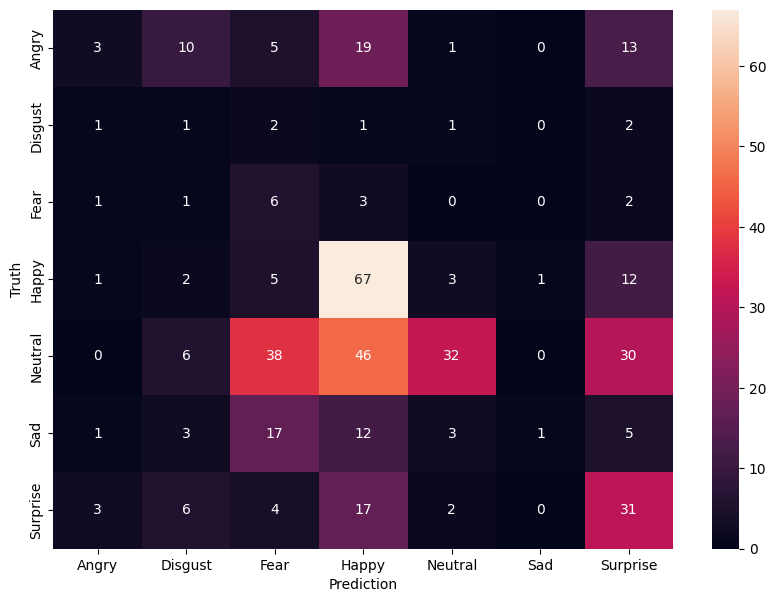

In [101]:

plt.figure(figsize = (10,7))
sn.heatmap(cm3, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [102]:
df4.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,FER_Prob,Predicted_Emotion_SER,SER_Prob,Predicted_Emotion_Text,TER_Prob,Predicted_Emotion_Ensemble,Predicted_Emotion_Ensemble_Probability
0,1,Hey!,All,Happy,positive,1,5,4,4,"0:12:44,074","0:12:45,189",dia1_utt5.mp4,Happy,0.837637,Surprise,0.998745,Happy,0.326344,NaN,NaN
1,2,Where?!,Rachel,Surprise,negative,1,7,4,4,"0:12:52,730","0:12:55,002",dia1_utt7.mp4,Sad,0.734680,Surprise,0.966066,Surprise,0.264435,NaN,NaN
2,3,Really?!,Estelle,Surprise,positive,2,3,6,4,"0:09:13,594","0:09:14,476",dia2_utt3.mp4,Angry,0.530724,Surprise,0.972096,Surprise,0.560124,NaN,NaN
3,4,Yeah!!,Ross,Happy,positive,3,1,5,20,"0:01:02,271","0:01:03,961",dia3_utt1.mp4,Happy,0.786309,Surprise,0.514668,Happy,0.455933,NaN,NaN
4,5,Wow! Whoa-whoa whats under the covers?,Rachel,Surprise,negative,15,4,8,7,"00:21:05,055","00:21:07,473",dia15_utt4.mp4,No Emotion,0.000000,Surprise,0.999857,Surprise,0.595369,NaN,NaN


In [103]:
df4 = df4.drop(['Predicted_Emotion_Ensemble', 'Predicted_Emotion_Ensemble_Probability'], axis=1)

In [107]:
df4.tail()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,FER_Prob,Predicted_Emotion_SER,SER_Prob,Predicted_Emotion_Text,TER_Prob
415,416,No.,Monica,Sad,negative,113,9,6,2,"00:19:28,792","00:19:29,876",dia113_utt9.mp4,Neutral,0.672034,Surprise,0.991877,Neutral,0.257405
416,417,What? Oh my God! Im gonna miss you so much!,Rachel,Sad,negative,113,10,6,2,"00:19:33,213","00:19:35,965",dia113_utt10.mp4,Sad,0.769026,Happy,0.998200,Happy,0.400086
417,418,Im gonna miss you!,Monica,Sad,negative,113,11,6,2,"00:19:36,175","00:19:37,967",dia113_utt11.mp4,No Emotion,0.000000,Surprise,0.741139,Happy,0.463362
418,419,I mean its the end of an era!,Rachel,Sad,negative,113,12,6,2,"00:19:39,094","00:19:40,928",dia113_utt12.mp4,Sad,0.844957,Surprise,0.985328,Happy,0.325146
419,420,I know!,Monica,Sad,negative,113,13,6,2,"00:19:41,138","00:19:42,638",dia113_utt13.mp4,Happy,0.907666,Surprise,0.969111,Happy,0.434210


In [105]:
FER = df4['Predicted_Emotion_FER']
SER = df4['Predicted_Emotion_SER']
TER = df4['Predicted_Emotion_Text']

FER_prob = df4['FER_Prob']
SER_prob = df4['SER_Prob']
TER_prob = df4['TER_Prob']

In [110]:
emotion_ensemble = []
prob_ensemble = []

for x in range(420):
  final_emotion = []
  final_probability =[]

  compile_emotion = [FER[x], SER[x], TER[x]]
  compile_emotion_prob = [FER_prob[x], SER_prob[x], TER_prob[x]]

  if ((compile_emotion[0] != compile_emotion[1]) and (compile_emotion[0] != compile_emotion[2]) and (compile_emotion[1] != compile_emotion[2])):
    idx = compile_emotion_prob.index(max(compile_emotion_prob))
    final_emotion.append(compile_emotion[idx])
    final_probability.append(max(compile_emotion_prob))

  else:
    final_emotion.append(statistics.mode(compile_emotion))

  if ((compile_emotion[0] == compile_emotion[1]) and (compile_emotion[0] == compile_emotion[2])):
    final_probability.append(statistics.mean(compile_emotion_prob))
  elif ((compile_emotion[0] == compile_emotion[1]) and (compile_emotion[0] != compile_emotion[2])) :
    final_probability.append((compile_emotion_prob[0]+compile_emotion_prob[1])/2)
  elif ((compile_emotion[0] == compile_emotion[2]) and (compile_emotion[0] != compile_emotion[1])):
    final_probability.append((compile_emotion_prob[0]+compile_emotion_prob[2])/2)
  elif ((compile_emotion[1] == compile_emotion[2]) and (compile_emotion[0] != compile_emotion[1])):
    final_probability.append((compile_emotion_prob[1]+compile_emotion_prob[2])/2)

  emotion_ensemble.append(final_emotion[0])
  prob_ensemble.append(final_probability[0])



In [111]:
df4['Predicted_Emotion_Ensemble'] = emotion_ensemble
df4['Predicted_Emotion_Ensemble_Probability'] = prob_ensemble

In [112]:
df4.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,FER_Prob,Predicted_Emotion_SER,SER_Prob,Predicted_Emotion_Text,TER_Prob,Predicted_Emotion_Ensemble,Predicted_Emotion_Ensemble_Probability
0,1,Hey!,All,Happy,positive,1,5,4,4,"0:12:44,074","0:12:45,189",dia1_utt5.mp4,Happy,0.837637,Surprise,0.998745,Happy,0.326344,Happy,0.581991
1,2,Where?!,Rachel,Surprise,negative,1,7,4,4,"0:12:52,730","0:12:55,002",dia1_utt7.mp4,Sad,0.734680,Surprise,0.966066,Surprise,0.264435,Surprise,0.615250
2,3,Really?!,Estelle,Surprise,positive,2,3,6,4,"0:09:13,594","0:09:14,476",dia2_utt3.mp4,Angry,0.530724,Surprise,0.972096,Surprise,0.560124,Surprise,0.766110
3,4,Yeah!!,Ross,Happy,positive,3,1,5,20,"0:01:02,271","0:01:03,961",dia3_utt1.mp4,Happy,0.786309,Surprise,0.514668,Happy,0.455933,Happy,0.621121
4,5,Wow! Whoa-whoa whats under the covers?,Rachel,Surprise,negative,15,4,8,7,"00:21:05,055","00:21:07,473",dia15_utt4.mp4,No Emotion,0.000000,Surprise,0.999857,Surprise,0.595369,Surprise,0.797613


In [113]:
y_true = df4['True_Emotion']
y_pred = df4['Predicted_Emotion_Ensemble']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       Angry       0.35      0.12      0.18        51
     Disgust       0.00      0.00      0.00         8
        Fear       0.24      0.31      0.27        13
       Happy       0.41      0.74      0.53        91
     Neutral       0.58      0.38      0.45       152
         Sad       0.36      0.21      0.27        42
    Surprise       0.41      0.63      0.50        63

    accuracy                           0.44       420
   macro avg       0.34      0.34      0.31       420
weighted avg       0.45      0.44      0.41       420



In [114]:

labels = np.unique(y_true)
cm4 = confusion_matrix(y_true, y_pred)
cm4 = pd.DataFrame(cm4, index=labels, columns=labels)

Text(95.72222222222221, 0.5, 'Truth')

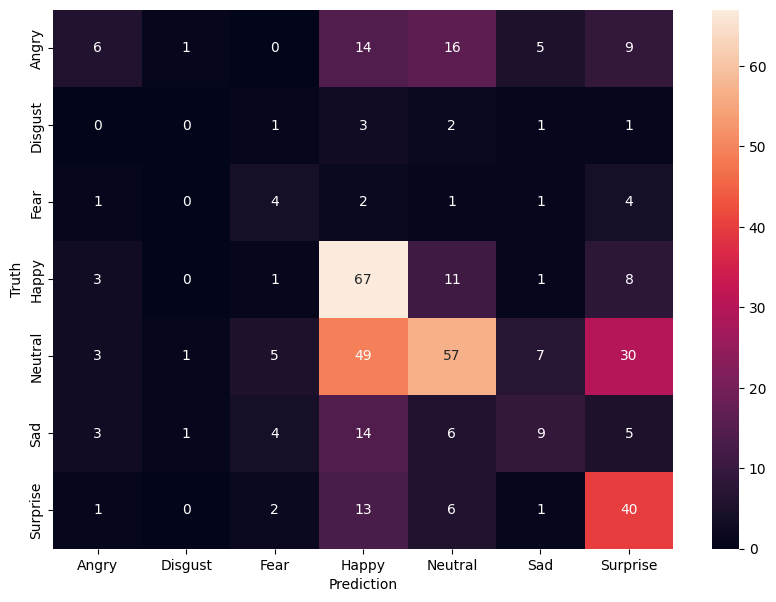

In [115]:
plt.figure(figsize = (10,7))
sn.heatmap(cm4, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

##**Only Combining FER and Text ER**

In [116]:
df5 = pd.read_csv("dev_sent_emo.csv")
df5.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,FER_Prob,Predicted_Emotion_SER,SER_Prob,Predicted_Emotion_Text,TER_Prob,Predicted_Emotion_Ensemble,Predicted_Emotion_Ensemble_Probability
0,1,Hey!,All,Happy,positive,1,5,4,4,"0:12:44,074","0:12:45,189",dia1_utt5.mp4,Happy,0.837637,Surprise,0.998745,Happy,0.326344,NaN,NaN
1,2,Where?!,Rachel,Surprise,negative,1,7,4,4,"0:12:52,730","0:12:55,002",dia1_utt7.mp4,Sad,0.734680,Surprise,0.966066,Surprise,0.264435,NaN,NaN
2,3,Really?!,Estelle,Surprise,positive,2,3,6,4,"0:09:13,594","0:09:14,476",dia2_utt3.mp4,Angry,0.530724,Surprise,0.972096,Surprise,0.560124,NaN,NaN
3,4,Yeah!!,Ross,Happy,positive,3,1,5,20,"0:01:02,271","0:01:03,961",dia3_utt1.mp4,Happy,0.786309,Surprise,0.514668,Happy,0.455933,NaN,NaN
4,5,Wow! Whoa-whoa whats under the covers?,Rachel,Surprise,negative,15,4,8,7,"00:21:05,055","00:21:07,473",dia15_utt4.mp4,No Emotion,0.000000,Surprise,0.999857,Surprise,0.595369,NaN,NaN


In [117]:
df5 = df5.drop(['Predicted_Emotion_Ensemble', 'Predicted_Emotion_Ensemble_Probability', 'Predicted_Emotion_SER', 'SER_Prob'], axis=1)

In [118]:
FER = df5['Predicted_Emotion_FER']
TER = df5['Predicted_Emotion_Text']

FER_prob = df5['FER_Prob']
TER_prob = df5['TER_Prob']

In [120]:
emotion_ensemble = []
prob_ensemble = []

for x in range(420):
  final_emotion = []
  final_probability =[]

  compile_emotion = [FER[x], TER[x]]
  compile_emotion_prob = [FER_prob[x], TER_prob[x]]

  if ((compile_emotion[0] != compile_emotion[1])):
    idx = compile_emotion_prob.index(max(compile_emotion_prob))
    final_emotion.append(compile_emotion[idx])
    final_probability.append(max(compile_emotion_prob))

  else:
    final_emotion.append(statistics.mode(compile_emotion))
    final_probability.append(statistics.mean(compile_emotion_prob))

  emotion_ensemble.append(final_emotion[0])
  prob_ensemble.append(final_probability[0])

In [121]:
df5['Predicted_Emotion_Ensemble'] = emotion_ensemble
df5['Predicted_Emotion_Ensemble_Probability'] = prob_ensemble

In [122]:
df5.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,FER_Prob,Predicted_Emotion_Text,TER_Prob,Predicted_Emotion_Ensemble,Predicted_Emotion_Ensemble_Probability
0,1,Hey!,All,Happy,positive,1,5,4,4,"0:12:44,074","0:12:45,189",dia1_utt5.mp4,Happy,0.837637,Happy,0.326344,Happy,0.581991
1,2,Where?!,Rachel,Surprise,negative,1,7,4,4,"0:12:52,730","0:12:55,002",dia1_utt7.mp4,Sad,0.734680,Surprise,0.264435,Sad,0.734680
2,3,Really?!,Estelle,Surprise,positive,2,3,6,4,"0:09:13,594","0:09:14,476",dia2_utt3.mp4,Angry,0.530724,Surprise,0.560124,Surprise,0.560124
3,4,Yeah!!,Ross,Happy,positive,3,1,5,20,"0:01:02,271","0:01:03,961",dia3_utt1.mp4,Happy,0.786309,Happy,0.455933,Happy,0.621121
4,5,Wow! Whoa-whoa whats under the covers?,Rachel,Surprise,negative,15,4,8,7,"00:21:05,055","00:21:07,473",dia15_utt4.mp4,No Emotion,0.000000,Surprise,0.595369,Surprise,0.595369


In [123]:
y_true = df5['True_Emotion']
y_pred = df5['Predicted_Emotion_Ensemble']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       Angry       0.31      0.29      0.30        51
     Disgust       0.00      0.00      0.00         8
        Fear       0.10      0.23      0.14        13
       Happy       0.48      0.55      0.51        91
     Neutral       0.48      0.38      0.43       152
         Sad       0.17      0.45      0.25        42
    Surprise       1.00      0.05      0.09        63

    accuracy                           0.35       420
   macro avg       0.36      0.28      0.24       420
weighted avg       0.49      0.35      0.34       420



##**Only Combining FER and SER**

In [124]:
df5 = pd.read_csv("dev_sent_emo.csv")
df5.head()

,Sr No.,Utterance,Speaker,True_Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,File_Name_Concatenated,Predicted_Emotion_FER,FER_Prob,Predicted_Emotion_SER,SER_Prob,Predicted_Emotion_Text,TER_Prob,Predicted_Emotion_Ensemble,Predicted_Emotion_Ensemble_Probability
0,1,Hey!,All,Happy,positive,1,5,4,4,"0:12:44,074","0:12:45,189",dia1_utt5.mp4,Happy,0.837637,Surprise,0.998745,Happy,0.326344,NaN,NaN
1,2,Where?!,Rachel,Surprise,negative,1,7,4,4,"0:12:52,730","0:12:55,002",dia1_utt7.mp4,Sad,0.734680,Surprise,0.966066,Surprise,0.264435,NaN,NaN
2,3,Really?!,Estelle,Surprise,positive,2,3,6,4,"0:09:13,594","0:09:14,476",dia2_utt3.mp4,Angry,0.530724,Surprise,0.972096,Surprise,0.560124,NaN,NaN
3,4,Yeah!!,Ross,Happy,positive,3,1,5,20,"0:01:02,271","0:01:03,961",dia3_utt1.mp4,Happy,0.786309,Surprise,0.514668,Happy,0.455933,NaN,NaN
4,5,Wow! Whoa-whoa whats under the covers?,Rachel,Surprise,negative,15,4,8,7,"00:21:05,055","00:21:07,473",dia15_utt4.mp4,No Emotion,0.000000,Surprise,0.999857,Surprise,0.595369,NaN,NaN


In [126]:
df5 = df5.drop(['Predicted_Emotion_Ensemble', 'Predicted_Emotion_Ensemble_Probability', 'Predicted_Emotion_Text', 'TER_Prob'], axis=1)

In [127]:
FER = df5['Predicted_Emotion_FER']
SER = df5['Predicted_Emotion_SER']

FER_prob = df5['FER_Prob']
SER_prob = df5['SER_Prob']

In [128]:
emotion_ensemble = []
prob_ensemble = []

for x in range(420):
  final_emotion = []
  final_probability =[]

  compile_emotion = [FER[x], SER[x]]
  compile_emotion_prob = [FER_prob[x], SER_prob[x]]

  if ((compile_emotion[0] != compile_emotion[1])):
    idx = compile_emotion_prob.index(max(compile_emotion_prob))
    final_emotion.append(compile_emotion[idx])
    final_probability.append(max(compile_emotion_prob))

  else:
    final_emotion.append(statistics.mode(compile_emotion))
    final_probability.append(statistics.mean(compile_emotion_prob))

  emotion_ensemble.append(final_emotion[0])
  prob_ensemble.append(final_probability[0])

In [129]:
df5['Predicted_Emotion_Ensemble'] = emotion_ensemble
df5['Predicted_Emotion_Ensemble_Probability'] = prob_ensemble

In [130]:
y_true = df5['True_Emotion']
y_pred = df5['Predicted_Emotion_Ensemble']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       Angry       0.33      0.10      0.15        51
     Disgust       0.00      0.00      0.00         8
        Fear       0.13      0.15      0.14        13
       Happy       0.35      0.57      0.43        91
     Neutral       0.46      0.28      0.35       152
         Sad       0.24      0.19      0.21        42
    Surprise       0.33      0.59      0.42        63

    accuracy                           0.35       420
   macro avg       0.26      0.27      0.24       420
weighted avg       0.36      0.35      0.33       420

